In \[1\]:

    import pandas as panda
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem.porter import *
    import string
    import nltk
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics import confusion_matrix
    import seaborn
    from textstat.textstat import textstat
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import f1_score
    from sklearn.feature_selection import SelectFromModel
    from sklearn.metrics import classification_report
    from sklearn.metrics import accuracy_score
    from sklearn.svm import LinearSVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.naive_bayes import GaussianNB
    import numpy as np
    from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    %matplotlib inline

In \[2\]:

    dataset = panda.read_csv("Hatespeech.csv")
    dataset

Out\[2\]:

|       | Unnamed: 0 | count | hate_speech | offensive_language | neither | class | tweet                                                 |
|-------|------------|-------|-------------|--------------------|---------|-------|-------------------------------------------------------|
| 0     | 0          | 3     | 0           | 0                  | 3       | 2     | !!! RT @mayasolovely: As a woman you shouldn't...     |
| 1     | 1          | 3     | 0           | 3                  | 0       | 1     | !!!!! RT @mleew17: boy dats cold...tyga dwn ba...     |
| 2     | 2          | 3     | 0           | 3                  | 0       | 1     | !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...     |
| 3     | 3          | 3     | 0           | 2                  | 1       | 1     | !!!!!!!!! RT @C_G\_Anderson: @viva_based she lo...    |
| 4     | 4          | 6     | 0           | 6                  | 0       | 1     | !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...     |
| ...   | ...        | ...   | ...         | ...                | ...     | ...   | ...                                                   |
| 24778 | 25291      | 3     | 0           | 2                  | 1       | 1     | you's a muthaf\*\*\*in lie &\#8220;@LifeAsKing: @2... |
| 24779 | 25292      | 3     | 0           | 1                  | 2       | 2     | you've gone and broke the wrong heart baby, an...     |
| 24780 | 25294      | 3     | 0           | 3                  | 0       | 1     | young buck wanna eat!!.. dat nigguh like I ain...     |
| 24781 | 25295      | 6     | 0           | 6                  | 0       | 1     | youu got wild bitches tellin you lies                 |
| 24782 | 25296      | 3     | 0           | 0                  | 3       | 2     | \~\~Ruffled \| Ntac Eileen Dahlia - Beautiful col...  |

24783 rows × 7 columns

In \[3\]:

    # Adding text-length as a field in the dataset
    dataset['text length'] = dataset['tweet'].apply(len)
    print(dataset.head())

       Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
    0           0      3            0                   0        3      2   
    1           1      3            0                   3        0      1   
    2           2      3            0                   3        0      1   
    3           3      3            0                   2        1      1   
    4           4      6            0                   6        0      1   

                                                   tweet  text length  
    0  !!! RT @mayasolovely: As a woman you shouldn't...          140  
    1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...           85  
    2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...          120  
    3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...           62  
    4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...          137  

In \[4\]:

    # collecting only the tweets from the csv file into a variable name tweet
    tweet=dataset.tweet

In \[5\]:

    ## 1. Removal of punctuation and capitlization
    ## 2. Tokenizing
    ## 3. Removal of stopwords
    ## 4. Stemming

    stopwords = nltk.corpus.stopwords.words("english")

    #extending the stopwords to include other words used in twitter such as retweet(rt) etc.
    other_exclusions = ["#ff", "ff", "rt"]
    stopwords.extend(other_exclusions)
    stemmer = PorterStemmer()

    def preprocess(tweet):  
        
        # removal of extra spaces
        regex_pat = re.compile(r'\s+')
        tweet_space = tweet.str.replace(regex_pat, ' ')

        # removal of @name[mention]
        regex_pat = re.compile(r'@[\w\-]+')
        tweet_name = tweet_space.str.replace(regex_pat, '')

        # removal of links[https://abc.com]
        giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
                '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        tweets = tweet_name.str.replace(giant_url_regex, '')
        
        # removal of punctuations and numbers
        punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
        # remove whitespace with a single space
        newtweet=punc_remove.str.replace(r'\s+', ' ')
        # remove leading and trailing whitespace
        newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
        # replace normal numbers with numbr
        newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
        # removal of capitalization
        tweet_lower = newtweet.str.lower()
        
        # tokenizing
        tokenized_tweet = tweet_lower.apply(lambda x: x.split())
        
        # removal of stopwords
        tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
        
        # stemming of the tweets
        tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
        
        for i in range(len(tokenized_tweet)):
            tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
            tweets_p= tokenized_tweet
        
        return tweets_p

    processed_tweets = preprocess(tweet)   

    dataset['processed_tweets'] = processed_tweets
    print(dataset[["tweet","processed_tweets"]].head(10))

                                                   tweet  \
    0  !!! RT @mayasolovely: As a woman you shouldn't...   
    1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
    2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
    3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
    4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   
    5  !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...   
    6  !!!!!!"@__BrighterDays: I can not just sit up ...   
    7  !!!!&#8220;@selfiequeenbri: cause I'm tired of...   
    8  " &amp; you might not get ya bitch back &amp; ...   
    9  " @rhythmixx_ :hobbies include: fighting Maria...   

                                        processed_tweets  
    0  woman complain clean hous amp man alway take t...  
    1  boy dat cold tyga dwn bad cuffin dat hoe st place  
    2         dawg ever fuck bitch start cri confus shit  
    3                                   look like tranni  
    4     shit hear might true might faker bitch told ya  
    5      shit blow claim faith somebodi still fuck hoe  
    6              sit hate anoth bitch got much shit go  
    7            caus tire big bitch come us skinni girl  
    8               amp might get ya bitch back amp that  
    9                    hobbi includ fight mariam bitch  

In \[6\]:

    #Visualizations

In \[7\]:

    # visualizing which of the word is most commonly used in the twitter dataset
    from matplotlib import pyplot as plt
    from wordcloud import WordCloud
    # imshow-Display data as an image
    # interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
    all_words = ' '.join([text for text in dataset['processed_tweets'] ])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    #random=0.30
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

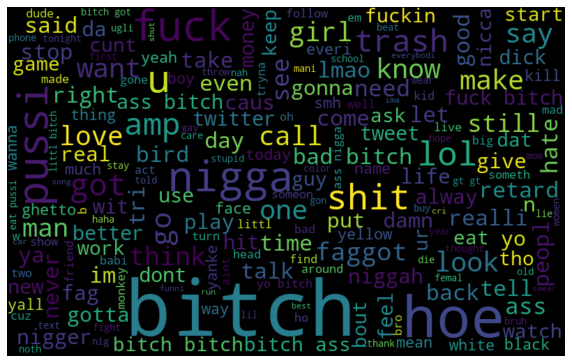

In \[8\]:

    # visualizing which of the word is most commonly used for hatred speech
    hatred_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 0]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(hatred_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

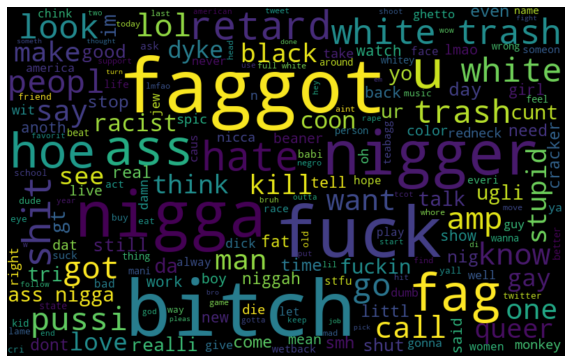

In \[9\]:

    # visualizing which of the word is most commonly used for offensive speech
    offensive_words = ' '.join([text for text in dataset['processed_tweets'][dataset['class'] == 1]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(offensive_words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

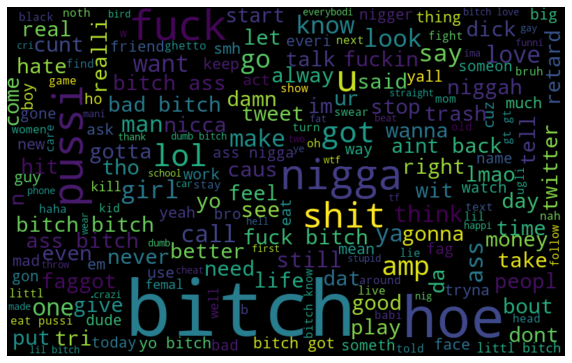

In \[10\]:

    #Feature Engineering 

In \[11\]:

    #TF-IDF Features-F1
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

    # TF-IDF feature matrix
    tfidf = tfidf_vectorizer.fit_transform(dataset['processed_tweets'] )
    tfidf

Out\[11\]:

    <24783x6441 sparse matrix of type '<class 'numpy.float64'>'
        with 189618 stored elements in Compressed Sparse Row format>

In \[12\]:

    #Running various model using TFIDF without additional features

In \[13\]:

    # If you don't specify the random_state in the code, 
    # then every time you run(execute) your code a new random value is generated 
    # and the train and test datasets would have different values each time.
    X = tfidf
    y = dataset['class'].astype(int)
    X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    model = LogisticRegression().fit(X_train_tfidf,y_train)
    y_preds = model.predict(X_test_tfidf)
    report = classification_report( y_test, y_preds )
    print(report)
    acc=accuracy_score(y_test,y_preds)
    print("Logistic Regression, Accuracy Score:" , acc)

                  precision    recall  f1-score   support

               0       0.56      0.18      0.27       290
               1       0.92      0.96      0.94      3832
               2       0.85      0.84      0.85       835

        accuracy                           0.90      4957
       macro avg       0.77      0.66      0.68      4957
    weighted avg       0.88      0.90      0.88      4957

    Logistic Regression, Accuracy Score: 0.8975186604801291

    C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
    STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

    Increase the number of iterations (max_iter) or scale the data as shown in:
        https://scikit-learn.org/stable/modules/preprocessing.html
    Please also refer to the documentation for alternative solver options:
        https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
      n_iter_i = _check_optimize_result(

In \[14\]:

    X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    rf=RandomForestClassifier()
    rf.fit(X_train_tfidf,y_train)
    y_preds = rf.predict(X_test_tfidf)
    acc1=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("Random Forest, Accuracy Score:",acc1)

                  precision    recall  f1-score   support

               0       0.52      0.17      0.26       290
               1       0.93      0.96      0.94      3832
               2       0.83      0.91      0.87       835

        accuracy                           0.90      4957
       macro avg       0.76      0.68      0.69      4957
    weighted avg       0.89      0.90      0.89      4957

    Random Forest, Accuracy Score: 0.9043776477708292

In \[15\]:

    X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)
    nb=GaussianNB()
    nb.fit(X_train_tfidf,y_train)
    y_preds = nb.predict(X_test_tfidf)
    acc2=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("Naive Bayes, Accuracy Score:",acc2)

                  precision    recall  f1-score   support

               0       0.10      0.39      0.16       290
               1       0.89      0.68      0.77      3832
               2       0.54      0.58      0.56       835

        accuracy                           0.65      4957
       macro avg       0.51      0.55      0.50      4957
    weighted avg       0.79      0.65      0.70      4957

    Naive Bayes, Accuracy Score: 0.6491829735727255

In \[16\]:

    support =LinearSVC(random_state=20)
    support.fit(X_train_tfidf,y_train)
    y_preds = support.predict(X_test_tfidf)
    acc3=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("SVM, Accuracy Score:" , acc3)

                  precision    recall  f1-score   support

               0       0.46      0.26      0.33       290
               1       0.92      0.95      0.94      3832
               2       0.83      0.85      0.84       835

        accuracy                           0.89      4957
       macro avg       0.74      0.69      0.70      4957
    weighted avg       0.88      0.89      0.89      4957

    SVM, Accuracy Score: 0.8932822271535202

In \[17\]:

    objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
    y_pos = np.arange(len(objects))
    performance = [acc,acc1,acc2,acc3]
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Accuracy')
    plt.title('Algorithm Comparision for F1')
    plt.show()

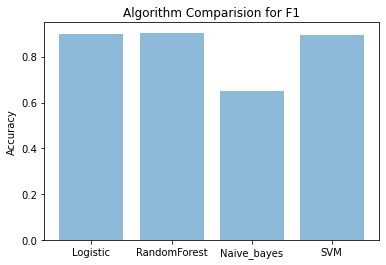

In \[18\]:

    #Sentiment analysis,using polarity scores as features

In \[19\]:

    import nltk
    nltk.downloader.download('vader_lexicon')
    sentiment_analyzer = VS()
    def count_tags(tweet_c):  
        
        space_pattern = '\s+'
        giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        mention_regex = '@[\w\-]+'
        hashtag_regex = '#[\w\-]+'
        parsed_text = re.sub(space_pattern, ' ', tweet_c)
        parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
        parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
        parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
        return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

    def sentiment_analysis(tweet):   
        sentiment = sentiment_analyzer.polarity_scores(tweet)    
        twitter_objs = count_tags(tweet)
        features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],twitter_objs[0], twitter_objs[1],
                    twitter_objs[2]]
        #features = pandas.DataFrame(features)
        return features

    def sentiment_analysis_array(tweets):
        features=[]
        for t in tweets:
            features.append(sentiment_analysis(t))
        return np.array(features)

    final_features = sentiment_analysis_array(tweet)
    #final_features

    new_features = panda.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3],
                                'url_tag':final_features[:,4],'mention_tag':final_features[:,5],'hash_tag':final_features[:,6]})
    new_features

    [nltk_data] Downloading package vader_lexicon to
    [nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
    [nltk_data]   Package vader_lexicon is already up-to-date!

Out\[19\]:

|       | Neg   | Pos   | Neu   | Compound | url_tag | mention_tag | hash_tag |
|-------|-------|-------|-------|----------|---------|-------------|----------|
| 0     | 0.000 | 0.120 | 0.880 | 0.4563   | 0.0     | 1.0         | 0.0      |
| 1     | 0.237 | 0.000 | 0.763 | -0.6876  | 0.0     | 1.0         | 0.0      |
| 2     | 0.538 | 0.000 | 0.462 | -0.9550  | 0.0     | 2.0         | 0.0      |
| 3     | 0.000 | 0.344 | 0.656 | 0.5673   | 0.0     | 2.0         | 0.0      |
| 4     | 0.249 | 0.081 | 0.669 | -0.7762  | 0.0     | 1.0         | 1.0      |
| ...   | ...   | ...   | ...   | ...      | ...     | ...         | ...      |
| 24778 | 0.000 | 0.000 | 1.000 | 0.0000   | 0.0     | 3.0         | 3.0      |
| 24779 | 0.454 | 0.000 | 0.546 | -0.8074  | 0.0     | 0.0         | 0.0      |
| 24780 | 0.000 | 0.219 | 0.781 | 0.4738   | 0.0     | 0.0         | 0.0      |
| 24781 | 0.573 | 0.000 | 0.427 | -0.7717  | 0.0     | 0.0         | 0.0      |
| 24782 | 0.000 | 0.218 | 0.782 | 0.5994   | 1.0     | 0.0         | 0.0      |

24783 rows × 7 columns

In \[20\]:

    # F2-Conctaenation of tf-idf scores and sentiment scores
    tfidf_a = tfidf.toarray()
    modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
    modelling_features.shape

Out\[20\]:

    (24783, 6448)

In \[21\]:

    #Running various model using TFIDF and additional features 

In \[22\]:

    # Running the model Using TFIDF with some features from sentiment analysis

    X = panda.DataFrame(modelling_features)
    y = dataset['class'].astype(int)
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

    model = LogisticRegression().fit(X_train_bow,y_train)
    y_preds = model.predict(X_test_bow)
    report = classification_report( y_test, y_preds )
    print(report)
    acc=accuracy_score(y_test,y_preds)
    print("Logistic Regression,Accuracy Score:" , acc)

    C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
    STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

    Increase the number of iterations (max_iter) or scale the data as shown in:
        https://scikit-learn.org/stable/modules/preprocessing.html
    Please also refer to the documentation for alternative solver options:
        https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
      n_iter_i = _check_optimize_result(

                  precision    recall  f1-score   support

               0       0.60      0.19      0.29       290
               1       0.92      0.96      0.94      3832
               2       0.85      0.84      0.85       835

        accuracy                           0.90      4957
       macro avg       0.79      0.67      0.69      4957
    weighted avg       0.89      0.90      0.89      4957

    Logistic Regression,Accuracy Score: 0.898930804922332

In \[23\]:

    X = panda.DataFrame(modelling_features)
    y = dataset['class'].astype(int)
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    rf=RandomForestClassifier()
    rf.fit(X_train_bow,y_train)
    y_preds = rf.predict(X_test_bow)
    acc1=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("Random Forest, Accuracy Score:",acc1)

                  precision    recall  f1-score   support

               0       0.54      0.15      0.23       290
               1       0.91      0.96      0.94      3832
               2       0.84      0.83      0.84       835

        accuracy                           0.89      4957
       macro avg       0.76      0.65      0.67      4957
    weighted avg       0.88      0.89      0.88      4957

    Random Forest, Accuracy Score: 0.8938874319144644

In \[24\]:

    X = panda.DataFrame(modelling_features)
    y = dataset['class'].astype(int)
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    nb=GaussianNB()
    nb.fit(X_train_bow,y_train)
    y_preds = nb.predict(X_test_bow)
    acc2=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("Naive Bayes, Accuracy Score:",acc2)

                  precision    recall  f1-score   support

               0       0.10      0.39      0.16       290
               1       0.89      0.68      0.77      3832
               2       0.54      0.59      0.56       835

        accuracy                           0.65      4957
       macro avg       0.51      0.55      0.50      4957
    weighted avg       0.79      0.65      0.70      4957

    Naive Bayes, Accuracy Score: 0.650191648174299

In \[25\]:

    X = panda.DataFrame(modelling_features)
    y = dataset['class'].astype(int)
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    support =LinearSVC(random_state=20)
    support.fit(X_train_bow,y_train)
    y_preds = support.predict(X_test_bow)
    acc3=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("SVM, Accuracy Score:" , acc3)

    C:\Users\dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
      warnings.warn("Liblinear failed to converge, increase "

                  precision    recall  f1-score   support

               0       0.46      0.26      0.33       290
               1       0.92      0.95      0.94      3832
               2       0.83      0.85      0.84       835

        accuracy                           0.89      4957
       macro avg       0.73      0.69      0.70      4957
    weighted avg       0.88      0.89      0.88      4957

    SVM, Accuracy Score: 0.8912648779503732

In \[26\]:

    objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
    y_pos = np.arange(len(objects))
    performance = [acc,acc1,acc2,acc3]
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Accuracy')
    plt.title('Algorithm Comparision for F2')
    plt.show()

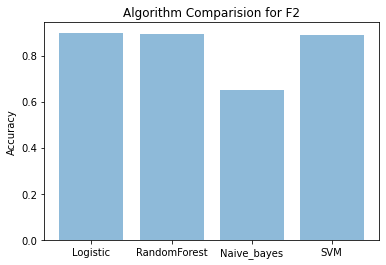

In \[27\]:

    # create doc2vec vector columns
    # Initialize and train the model
    from gensim.test.utils import common_texts
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument
    #The input for a Doc2Vec model should be a list of TaggedDocument(['list','of','word'], [TAG_001]). 
    #A good practice is using the indexes of sentences as the tags.
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dataset["processed_tweets"].apply(lambda x: x.split(" ")))]

    # train a Doc2Vec model with our text data
    # window- The maximum distance between the current and predicted word within a sentence.
    # mincount-Ignores all words with total frequency lower than this.
    # workers -Use these many worker threads to train the model
    #  Training Model - distributed bag of words (PV-DBOW) is employed.
    model = Doc2Vec(documents,vector_size=5, window=2, min_count=1, workers=4)

    #infer_vector - Infer a vector for given post-bulk training document.
    # Syntax- infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
    # doc_words-A document for which the vector representation will be inferred.

    # transform each document into a vector data
    doc2vec_df = dataset["processed_tweets"].apply(lambda x: model.infer_vector(x.split(" "))).apply(panda.Series)
    doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
    doc2vec_df

Out\[27\]:

|       | doc2vec_vector_0 | doc2vec_vector_1 | doc2vec_vector_2 | doc2vec_vector_3 | doc2vec_vector_4 |
|-------|------------------|------------------|------------------|------------------|------------------|
| 0     | 0.076885         | -0.017021        | 0.101520         | -0.197611        | 0.184609         |
| 1     | 0.111662         | 0.147367         | 0.120106         | -0.028936        | -0.074008        |
| 2     | -0.008754        | 0.126370         | 0.080510         | 0.003971         | 0.042777         |
| 3     | 0.001408         | 0.153325         | 0.013461         | -0.099059        | -0.040533        |
| 4     | -0.142033        | 0.066057         | -0.018793        | -0.174316        | -0.017638        |
| ...   | ...              | ...              | ...              | ...              | ...              |
| 24778 | 0.323929         | 0.043667         | 0.353385         | -0.284515        | 0.039147         |
| 24779 | -0.087375        | 0.039779         | 0.174589         | -0.011940        | -0.018413        |
| 24780 | -0.194213        | 0.210093         | 0.115051         | 0.212831         | -0.109230        |
| 24781 | 0.022204         | 0.016390         | -0.008144        | -0.147061        | -0.039355        |
| 24782 | 0.517087         | -0.251683        | 0.480176         | -0.424569        | 0.098824         |

24783 rows × 5 columns

In \[28\]:

    # conctaenation of tf-idf scores, sentiment scores and doc2vec columns
    modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
    modelling_features.shape

Out\[28\]:

    (24783, 6453)

In \[29\]:

    #Running the models using TFIDF with additional features from sentiment analysis and doc2vec

In \[30\]:

    X = panda.DataFrame(modelling_features)
    y = dataset['class'].astype(int)
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

    model = LogisticRegression().fit(X_train_bow,y_train)
    y_preds = model.predict(X_test_bow)
    report = classification_report( y_test, y_preds )
    print(report)
    acc=accuracy_score(y_test,y_preds)
    print("Logistic Regression, Accuracy Score:" , acc)

    C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
    STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

    Increase the number of iterations (max_iter) or scale the data as shown in:
        https://scikit-learn.org/stable/modules/preprocessing.html
    Please also refer to the documentation for alternative solver options:
        https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
      n_iter_i = _check_optimize_result(

                  precision    recall  f1-score   support

               0       0.60      0.18      0.28       290
               1       0.92      0.97      0.94      3832
               2       0.85      0.85      0.85       835

        accuracy                           0.90      4957
       macro avg       0.79      0.66      0.69      4957
    weighted avg       0.89      0.90      0.89      4957

    Logistic Regression, Accuracy Score: 0.8999394795239056

In \[31\]:

    X = panda.DataFrame(modelling_features)
    y = dataset['class'].astype(int)
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    rf=RandomForestClassifier()
    rf.fit(X_train_bow,y_train)
    y_preds = rf.predict(X_test_bow)
    acc1=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("Random Forest, Accuracy Score:",acc1)

                  precision    recall  f1-score   support

               0       0.51      0.08      0.13       290
               1       0.90      0.97      0.93      3832
               2       0.85      0.79      0.82       835

        accuracy                           0.89      4957
       macro avg       0.75      0.61      0.63      4957
    weighted avg       0.87      0.89      0.87      4957

    Random Forest, Accuracy Score: 0.8876336493847085

In \[32\]:

    X = panda.DataFrame(modelling_features)
    y = dataset['class'].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    nb=GaussianNB()
    nb.fit(X_train,y_train)
    y_preds = nb.predict(X_test)
    acc2=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("Naive Bayes, Accuracy Score:",acc2)

                  precision    recall  f1-score   support

               0       0.10      0.39      0.16       290
               1       0.89      0.68      0.77      3832
               2       0.54      0.59      0.56       835

        accuracy                           0.65      4957
       macro avg       0.51      0.55      0.50      4957
    weighted avg       0.79      0.65      0.70      4957

    Naive Bayes, Accuracy Score: 0.650191648174299

In \[33\]:

    X = panda.DataFrame(modelling_features)
    y = dataset['class'].astype(int)
    X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
    support =LinearSVC(random_state=20)
    support.fit(X_train_bow,y_train)
    y_preds = support.predict(X_test_bow)
    acc3=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("SVM, Accuracy Score:" , acc3)

    C:\Users\dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
      warnings.warn("Liblinear failed to converge, increase "

                  precision    recall  f1-score   support

               0       0.45      0.25      0.32       290
               1       0.92      0.95      0.94      3832
               2       0.83      0.85      0.84       835

        accuracy                           0.89      4957
       macro avg       0.73      0.68      0.70      4957
    weighted avg       0.88      0.89      0.88      4957

    SVM, Accuracy Score: 0.8916683477910026

In \[34\]:

    objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
    y_pos = np.arange(len(objects))
    performance = [acc,acc1,acc2,acc3]
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Accuracy')
    plt.title('Algorithm Comparision')
    plt.show()

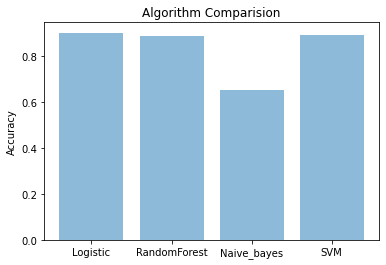

In \[35\]:

    #Using TFIDF with sentiment scores,doc2vec and enhanced features
    def additional_features(tweet): 
        
        syllables = textstat.syllable_count(tweet)
        num_chars = sum(len(w) for w in tweet)
        num_chars_total = len(tweet)
        num_words = len(tweet.split())
        # avg_syl = total syllables/ total words
        avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
        num_unique_terms = len(set(tweet.split()))
        
        #  Flesch–Kincaid readability tests are readability tests 
        #  designed to indicate how difficult a passage in English is to understand. 
        # There are two tests, the Flesch Reading Ease, and the Flesch–Kincaid Grade 
        # A text with a comparatively high score on FRE test should have a lower score on the FKRA test.
        # Reference - https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
        
        ###Modified FK grade, where avg words per sentence is : just num words/1
        FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
        ##Modified FRE score, where sentence fixed to 1
        FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
        
        add_features=[FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_words,
                    num_unique_terms]
        return add_features

    def get_additonal_feature_array(tweets):
        features=[]
        for t in tweets:
            features.append(additional_features(t))
        return np.array(features)

    fFeatures = get_additonal_feature_array(processed_tweets)

In \[36\]:

    tfidf_a = tfidf.toarray()
    modelling_features_enhanced = np.concatenate([tfidf_a,final_features,doc2vec_df,fFeatures],axis=1)
    modelling_features_enhanced.shape

Out\[36\]:

    (24783, 6461)

In \[37\]:

    #Running the models using TFIDF with sentiment scores,doc2vec and enhanced features

In \[38\]:

    # Running the model Using TFIDF with enhanced features

    X = panda.DataFrame(modelling_features_enhanced)
    y = dataset['class'].astype(int)
    X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

    model = LogisticRegression().fit(X_train_features,y_train)
    y_preds = model.predict(X_test_features)
    report = classification_report( y_test, y_preds )
    print(report)
    acc=accuracy_score(y_test,y_preds)
    print("Logistic Regression, Accuracy Score:" , acc)

    C:\Users\dell\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
    STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

    Increase the number of iterations (max_iter) or scale the data as shown in:
        https://scikit-learn.org/stable/modules/preprocessing.html
    Please also refer to the documentation for alternative solver options:
        https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
      n_iter_i = _check_optimize_result(

                  precision    recall  f1-score   support

               0       0.00      0.00      0.00       279
               1       0.83      0.96      0.89      3852
               2       0.64      0.41      0.50       826

        accuracy                           0.81      4957
       macro avg       0.49      0.45      0.46      4957
    weighted avg       0.75      0.81      0.77      4957

    Logistic Regression, Accuracy Score: 0.8107726447448054

    C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
      _warn_prf(average, modifier, msg_start, len(result))
    C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
      _warn_prf(average, modifier, msg_start, len(result))
    C:\Users\dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
      _warn_prf(average, modifier, msg_start, len(result))

In \[39\]:

    #Confusion Matrix for TFIDF with additional features 
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test,y_preds)
    matrix_proportions = np.zeros((3,3))
    for i in range(0,3):
        matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
    names=['Hate','Offensive','Neither']
    confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
    plt.figure(figsize=(5,5))
    seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
    plt.ylabel(r'True Value',fontsize=14)
    plt.xlabel(r'Predicted Value',fontsize=14)
    plt.tick_params(labelsize=12)

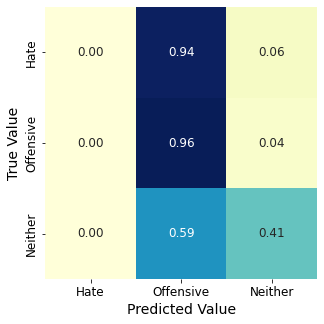

In \[40\]:

    # From the confusion matrix its clear that the model misclassifies 78% of the hate data as offensive data. This explains the reduction in class-0
    # bar on the histogram for the predicted class and increase of bar fo

In \[41\]:

    testing_index=list(X_test_features.index[0:10])
    #print(testing_index)
    print("Predicted Class:",y_preds[0:10])
    print("Actual Class:",y_test.tolist()[0:10])

    Predicted Class: [1 1 1 1 1 1 1 1 2 1]
    Actual Class: [2, 1, 1, 0, 2, 1, 1, 1, 2, 2]

In \[42\]:

    # Histogram presenting the count of different classes- Actual
    ax=y_test.hist()
    ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
    ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

Out\[42\]:

    Text(0, 0.5, 'Count')

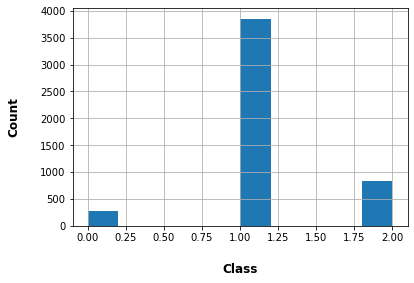

In \[43\]:

    # Histogram presenting the count of different classes- Predicted
    ax=panda.Series(y_preds).hist()
    ax.set_xlabel("Class", labelpad=20, weight='bold', size=12)
    ax.set_ylabel("Count", labelpad=20, weight='bold', size=12)

Out\[43\]:

    Text(0, 0.5, 'Count')

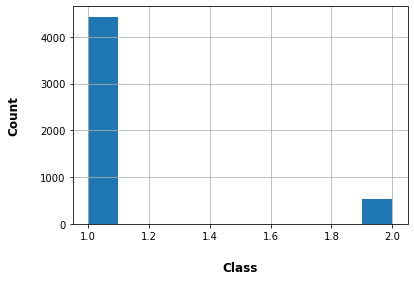

In \[44\]:

    X = panda.DataFrame(modelling_features_enhanced)
    y = dataset['class'].astype(int)
    X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
    rf=RandomForestClassifier()
    rf.fit(X_train_features,y_train)
    y_preds = rf.predict(X_test_features)
    acc1=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("Random Forest, Accuracy Score:",acc1)

                  precision    recall  f1-score   support

               0       0.40      0.04      0.07       279
               1       0.88      0.97      0.93      3852
               2       0.85      0.71      0.77       826

        accuracy                           0.88      4957
       macro avg       0.71      0.57      0.59      4957
    weighted avg       0.85      0.88      0.85      4957

    Random Forest, Accuracy Score: 0.8763364938470849

In \[45\]:

    X = panda.DataFrame(modelling_features_enhanced)
    y = dataset['class'].astype(int)
    X_train_features, X_test_features, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
    nb=GaussianNB()
    nb.fit(X_train_features,y_train)
    y_preds = nb.predict(X_test_features)
    acc2=accuracy_score(y_test,y_preds)
    report = classification_report( y_test, y_preds )
    print(report)
    print("Naive Bayes, Accuracy Score:",acc2)

                  precision    recall  f1-score   support

               0       0.09      0.36      0.15       279
               1       0.90      0.69      0.78      3852
               2       0.59      0.65      0.62       826

        accuracy                           0.66      4957
       macro avg       0.53      0.57      0.51      4957
    weighted avg       0.80      0.66      0.72      4957

    Naive Bayes, Accuracy Score: 0.662497478313496

In \[46\]:

    #Confusion Matrix for TFIDF with additional features 
    from sklearn.metrics import confusion_matrix
    confusion_matrix = confusion_matrix(y_test,y_preds)
    matrix_proportions = np.zeros((3,3))
    for i in range(0,3):
        matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
    names=['Hate','Offensive','Neither']
    confusion_df = panda.DataFrame(matrix_proportions, index=names,columns=names)
    plt.figure(figsize=(5,5))
    seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
    plt.ylabel(r'True Value',fontsize=14)
    plt.xlabel(r'Predicted Value',fontsize=14)
    plt.tick_params(labelsize=12)

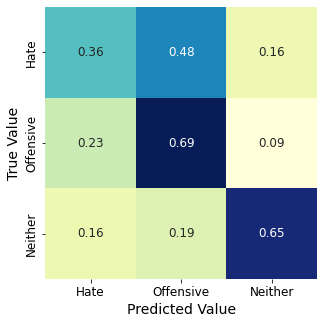

In \[47\]:

    X = panda.DataFrame(modelling_features_enhanced)
    y = dataset['class'].astype(int)
    X_train_features, X_test_features, y_train, y_test_helo = train_test_split(X, y, random_state=0, test_size=0.2)
    support =LinearSVC(random_state=20)
    support.fit(X_train_features,y_train)
    y_preds = support.predict(X_test_features)
    acc3=accuracy_score(y_test_helo,y_preds)
    report = classification_report( y_test_helo, y_preds )
    print(report)
    print("SVM, Accuracy Score:" ,acc3 )

    C:\Users\dell\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
      warnings.warn("Liblinear failed to converge, increase "

                  precision    recall  f1-score   support

               0       0.53      0.07      0.12       279
               1       0.86      0.98      0.92      3852
               2       0.89      0.56      0.69       826

        accuracy                           0.86      4957
       macro avg       0.76      0.54      0.58      4957
    weighted avg       0.85      0.86      0.84      4957

    SVM, Accuracy Score: 0.8624167843453702

In \[48\]:

    objects = ('Logistic', 'RandomForest', 'Naive_bayes', 'SVM')
    y_pos = np.arange(len(objects))
    performance = [acc,acc1,acc2,acc3]
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Accuracy')
    plt.title('Algorithm Comparision')
    plt.show()

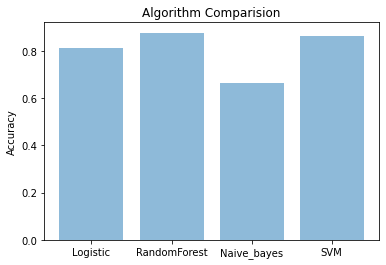